In [143]:
import os
import csv
import pandas as pd 
import numpy as np
import sklearn.datasets as datasets
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
#os.chdir("C:/Users/Pc/Dropbox/MachineLearning/3 Arboles")
os.chdir("C:/Users/rmaur/Dropbox/MachineLearning/3 Arboles")

In [144]:
data = pd.read_csv("baseclean.csv") 
data.head()

,action_taken,agency_code,applicant_ethnicity,applicant_income_000s,applicant_race_1,applicant_sex,application_date_indicator,census_tract_number,co_applicant_ethnicity,co_applicant_race_1,...,property_type,purchaser_type,sequence_number,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population,tract_to_msamd_income
0,1,9,3,230.0,6,3,0,319.00,5,8,...,1,0,155085,82700.0,159,2414.0,2077.0,14.770000,7442.0,138.440002
1,1,7,1,66.0,6,1,0,602.02,3,5,...,2,0,37462,95200.0,47,1422.0,1298.0,19.690001,3997.0,85.000000
2,1,7,3,NaN,6,3,0,4069.00,5,8,...,1,9,2434,109000.0,175,1675.0,1009.0,97.239998,7272.0,50.419998
3,1,5,2,174.0,5,1,0,502.03,2,5,...,1,0,20,95200.0,40,1723.0,1578.0,17.639999,4971.0,119.169998
4,1,9,2,100.0,5,2,0,195.00,5,8,...,1,0,12370,71300.0,378,615.0,738.0,60.779999,3366.0,78.169998


In [145]:
dataf=data
dataf=dataf.dropna()

In [146]:
values = np.array(dataf["county_name"])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
dataf.loc[:,"county_name"]=integer_encoded
print(dataf.groupby('action_taken').size())

action_taken
1    1951
2     129
3     630
4     353
5     142
6     273
dtype: int64


C:\Users\rmaur\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [147]:

X=dataf.iloc[:,1:]
Y=dataf.iloc[:,0]

train_X, test_X, train_y, test_y = train_test_split(X,Y, 
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=123)

In [148]:
dtree=DecisionTreeClassifier()
dtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [149]:
Importance = pd.DataFrame({'Variable': X.columns,
    'Valor':dtree.feature_importances_ })
Importance=Importance.sort_values('Valor',ascending=True)


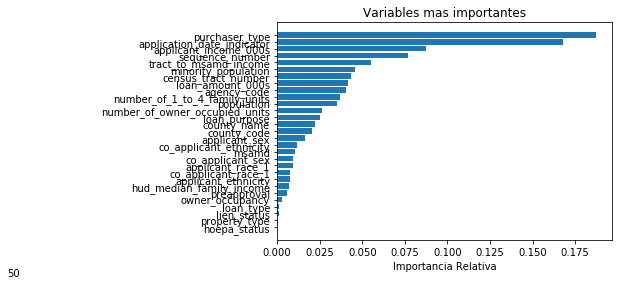

In [150]:
#ANALISIS DE IMPORTANCIA

import matplotlib.pyplot as plt
#Importance['Variable']
y_pos = np.arange(len(Importance['Valor']))

plt.barh(y_pos,Importance['Valor'],align='center')
plt.yticks(y_pos, Importance['Variable'])
plt.xlabel('Importancia Relativa')
plt.figtext(-0.5,0,50)
plt.title('Variables mas importantes')

In [151]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


fold = KFold(n_splits=20, random_state=123)

cv_results = model_selection.cross_val_score(dtree, train_X, train_y, cv=fold, scoring='accuracy')
cv_results

array([0.63114754, 0.6557377 , 0.6147541 , 0.59016393, 0.67213115,
       0.64754098, 0.6557377 , 0.64754098, 0.6557377 , 0.75409836,
       0.64754098, 0.64754098, 0.68032787, 0.68032787, 0.7107438 ,
       0.52892562, 0.66115702, 0.6446281 , 0.6446281 , 0.61157025])

In [152]:
cv_results.mean()
dtree.decision_path


<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

In [253]:
predictions=dtree.predict(test_X)
acc=accuracy_score(test_y, predictions)
Predi = pd.DataFrame({'Class':test_y,
    'Predictions':predictions})
confusion_matrix(test_y, predictions)
#PREDICE BIEN EL 1. El lo predice de una

array([[489,  11,  46,  33,  13,   0],
       [ 12,   4,  10,   9,   3,   0],
       [ 54,   5,  78,  39,  14,   0],
       [ 19,   6,  30,  31,   9,   0],
       [ 13,   5,  21,  13,   2,   0],
       [  0,   0,   0,   0,   0,  75]], dtype=int64)

In [161]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=10)
clf.fit(X=X, y=Y)
tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_,clf.best_estimator_)

C:\Users\rmaur\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.7156411730879816 {'max_depth': 5} DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [304]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:2,2:1,3:2,4:1,5:1,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 2, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [313]:
 adtree=DecisionTreeClassifier(max_depth=7,criterion='entropy',
                              class_weight= {1:4,2:2,3:4,4:2,5:3,6:1})
#PRUEBO UN MAX DEPTH 5, PERO CON 7 DA1 MEJORpy Y ENTROPIA

adtree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight={1: 4, 2: 2, 3: 4, 4: 2, 5: 3, 6: 1},
            criterion='entropy', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [314]:
predictions=adtree.predict(test_X)
acc=accuracy_score(test_y, predictions)
acc

0.7068965517241379

In [142]:
?GridSearchCV


Init signature:
GridSearchCV(
    ['estimator', 'param_grid', 'scoring=None', 'fit_params=None', 'n_jobs=None', "iid='warn'", 'refit=True', "cv='warn'", 'verbose=0', "pre_dispatch='2*n_jobs'", "error_score='raise-deprecating'", "return_train_score='warn'"],
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "predict", "predict_proba", "decision_function",
"transform" and "inverse_transform" if they are implemented in the
estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object.
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : 